# Common Vulnerabilities and Exposures (CVE)

## Exploratory Data Analysis

Common Vulnerabilities and Exposures (CVE) is a list of computer security threats provided by the U.S. Department of Homeland Security and maintained by the MITRE corporation. 

CVE was launched in 1999 by the MITRE corporation to identify and categorize vulnerabilities in software and firmware. CVE provides a free dictionary for organizations to improve their cyber security. MITRE is a nonprofit that operates federally funded research and development centers in the United States.

A CVE entry describes a known vulnerability or exposure. Each CVE entry contains a standard identifier number with status indicator (i.e. "CVE-1999-0067", "CVE-2014-12345", "CVE-2016-7654321"), a brief description and references related vulnerability reports and advisories. Each CVE ID is formatted as CVE-YYYY-NNNNN. The YYYY portion is the year the CVE ID was assigned or the year the vulnerability was made public. Unlike vulnerability databases, CVE entries do not include risk, impact fix or other technical information.

In [1]:
import numpy as np
import pandas as pd 

import os
import re

import missingno as msno 
import string 
import seaborn as sns 
import matplotlib.pyplot as plt

import scipy.optimize as opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import scipy.stats as sps

In [2]:
cve = pd.read_csv('data/cve.csv', header=0, index_col=0)
products = pd.read_csv('data/products.csv', header=0, index_col=0)
vendors = pd.read_csv('data/vendors.csv', header=0, index_col=0)

***
**CVE**
***

In [3]:
cve.head()

mod_date             pub_date  cvss  cwe_code  \
CVE-2019-16548  2019-11-21 15:15:00  2019-11-21 15:15:00   6.8       352   
CVE-2019-16547  2019-11-21 15:15:00  2019-11-21 15:15:00   4.0       732   
CVE-2019-16546  2019-11-21 15:15:00  2019-11-21 15:15:00   4.3       639   
CVE-2013-2092   2019-11-20 21:22:00  2019-11-20 21:15:00   4.3        79   
CVE-2013-2091   2019-11-20 20:15:00  2019-11-20 20:15:00   7.5        89   

                                                         cwe_name  \
CVE-2019-16548                  Cross-Site Request Forgery (CSRF)   
CVE-2019-16547   Incorrect Permission Assignment for Critical ...   
CVE-2019-16546   Authorization Bypass Through User-Controlled Key   
CVE-2013-2092    Improper Neutralization of Input During Web P...   
CVE-2013-2091    Improper Neutralization of Special Elements u...   

                                                          summary  \
CVE-2019-16548  A cross-site request forgery vulnerability in ...   
CVE-2019-16547  Missing permission checks in various API endpo...   
CVE-2019-16546  Jenkins Google Compute Engine Plugin 4.1.1 and...   
CVE-2013-2092   Cross-site Scripting (XSS) in Dolibarr ERP/CRM...   
CVE-2013-2091   SQL injection vulnerability in Dolibarr ERP/CR...   

               access_authentication access_complexity access_vector  \
CVE-2019-16548                   NaN               NaN           NaN   
CVE-2019-16547                   NaN               NaN           NaN   
CVE-2019-16546                   NaN               NaN           NaN   
CVE-2013-2092                    NaN               NaN           NaN   
CVE-2013-2091                    NaN               NaN           NaN   

               impact_availability impact_confidentiality impact_integrity  
CVE-2019-16548                 NaN                    NaN              NaN  
CVE-2019-16547                 NaN                    NaN              NaN  
CVE-2019-16546                 NaN                    NaN              NaN  
CVE-2013-2092                  NaN                    NaN              NaN  
CVE-2013-2091                  NaN                    NaN              NaN

***
**Features Description**
***

| attribute | dtype  | description 
| :-- | :-- | :--
| mod_date | datetime | The date the entry was last modified 
| pub_date | datetime | The date the entry was published
| cvss | float | Common Vulnerability Scoring System (CVSS) score, a measure of the severity of a vulnerability 
| cwe_code | categorical | Common Weakness Enumeration (CWE) code, identifying the type of weakness
| cwe_name | categorical | The name associated with the CWE code
| summary | str | A text summary of the vulnerability
| access_authentication | categorical | {NONE, SINGLE, MULTIPLE}
| access_complexity | categorical | {LOW, MEDIUM, HIGH}
| access_vector | categorical | {LOCAL, NETWORK, ADJACENT NETWORK}
| impact_availability | categorical | {NONE, PARTIAL, COMPLETE}
| impact_confidentiality | categorical | {NONE, PARTIAL, COMPLETE}
| impact_integrity | categorical | {NONE, PARTIAL, COMPLETE}

In [4]:
cve.shape

(89660, 12)

In [5]:
cve.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 89660 entries, CVE-2019-16548 to CVE-2007-3004
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mod_date                89660 non-null  object 
 1   pub_date                89660 non-null  object 
 2   cvss                    89660 non-null  float64
 3   cwe_code                89660 non-null  int64  
 4   cwe_name                89660 non-null  object 
 5   summary                 89660 non-null  object 
 6   access_authentication   88776 non-null  object 
 7   access_complexity       88776 non-null  object 
 8   access_vector           88776 non-null  object 
 9   impact_availability     88776 non-null  object 
 10  impact_confidentiality  88776 non-null  object 
 11  impact_integrity        88776 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 90.4 MB


In [6]:
cve.describe()

cvss      cwe_code
count  89660.000000  89660.000000
mean       6.021429    199.690854
std        1.994757    176.177244
min        0.000000      1.000000
25%        4.300000     79.000000
50%        5.800000    119.000000
75%        7.500000    284.000000
max       10.000000   1188.000000

Here it is important to take a closer look at the ranges of the values. If the max or min of a feature is significantly different from the mean and from the 75% / 25%, we might want to look into this further to understand if these values make sense in their context.

In [7]:
cve.mod_date = pd.to_datetime(cve.mod_date)
cve.pub_date = pd.to_datetime(cve.pub_date)

In [8]:
cve.duplicated().sum()

1176

In [9]:
cve = cve.drop_duplicates()

Heatmap takes a rectangular data grid as input and then assigns a color intensity to each data cell based on the data value of the cell. This is a great way to get visual clues about the data.

We will generate a heatmap of the output of isnull() in order to detect missing values.

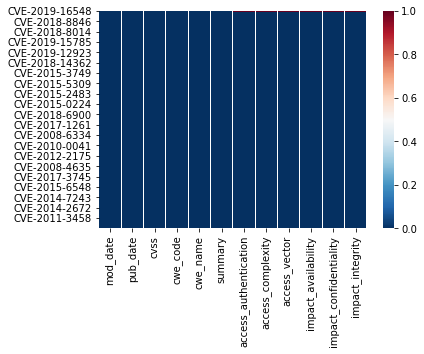

In [10]:
sns.heatmap(cve.isnull(), cmap="RdBu_r")
plt.show()

We can handle missing values in many ways:

- Delete: We can delete the rows with the missing values or delete the whole column which has missing values. The dropna() method from Pandas library can be used to accomplish this task.
- Impute: Deleting data might cause huge amount of information loss. So, replacing data might be a better option than deleting. One standard replacement technique is to replace missing values with the average value of the entire column for numerical features, or replace missing values with the most frequent feature for categorical values.
- Predictive filling: Alternatively, you can choose to fill missing values through predictive filling. The interpolate() method will perform a linear interpolation in order to “guess” the missing values and fill the results in the dataset.

In [11]:
cve = cve.dropna(axis=0, how='any',thresh=None, subset=None, inplace=False)

In [12]:
obj_types = ['access_authentication', 'access_complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', 'impact_integrity']

In [13]:
def transform_to_int(train, obj_types):
    #Assign dictionaries with current values and replacements for each column
    d_aa = {'NONE':0, 'SINGLE':1, 'MULTIPLE':2}
    d_ac = {'LOW':0, 'MEDIUM':1, 'HIGH':2}
    d_av = {'LOCAL':0, 'NETWORK':1, 'ADJACENT_NETWORK':2}
    d_ia = {'NONE':0, 'PARTIAL':1, 'COMPLETE':2}
    d_ic = {'NONE':0, 'PARTIAL':1, 'COMPLETE':2}
    d_ii = {'NONE':0, 'PARTIAL':1, 'COMPLETE':2}
    #Each positional index in replacements corresponds to the column in obj_types
    replacements = [d_aa, d_ac, d_av, d_ia, d_ic, d_ii]

    #Replace using lambda Series.map(lambda)
    for i,col in enumerate(obj_types):
        train[col] = train[col].map(lambda a: replacements[i][a]).astype('int64')

In [14]:
cve.access_vector = cve.access_vector.str.replace('ADJACENT NETWORK', 'ADJACENT_NETWORK')

In [15]:
transform_to_int(cve, obj_types)

In [16]:
cve.head()

mod_date            pub_date  cvss  cwe_code  \
CVE-2019-2211  2019-11-14 21:36:00 2019-11-13 18:15:00   7.8        89   
CVE-2019-2212  2019-11-14 21:30:00 2019-11-13 18:15:00   4.9       200   
CVE-2019-2213  2019-11-14 21:24:00 2019-11-13 18:15:00   6.9       416   
CVE-2019-2214  2019-11-14 21:19:00 2019-11-13 18:15:00   7.2       269   
CVE-2019-18793 2019-11-14 21:14:00 2019-11-13 20:15:00   4.3        79   

                                                         cwe_name  \
CVE-2019-2211    Improper Neutralization of Special Elements u...   
CVE-2019-2212                                Information Exposure   
CVE-2019-2213                                      Use After Free   
CVE-2019-2214                       Improper Privilege Management   
CVE-2019-18793   Improper Neutralization of Input During Web P...   

                                                          summary  \
CVE-2019-2211   In createProjectionMapForQuery of TvProvider.j...   
CVE-2019-2212   In poisson_distribution of random, there is an...   
CVE-2019-2213   In binder_free_transaction of binder.c, there ...   
CVE-2019-2214   In binder_transaction of binder.c, there is a ...   
CVE-2019-18793  Parallels Plesk Panel 9.5 allows XSS in target...   

                access_authentication  access_complexity  access_vector  \
CVE-2019-2211                       0                  0              1   
CVE-2019-2212                       0                  0              0   
CVE-2019-2213                       0                  1              0   
CVE-2019-2214                       0                  0              0   
CVE-2019-18793                      0                  1              1   

                impact_availability  impact_confidentiality  impact_integrity  
CVE-2019-2211                     0                       2                 0  
CVE-2019-2212                     0                       2                 0  
CVE-2019-2213                     2                       2                 2  
CVE-2019-2214                     2                       2                 2  
CVE-2019-18793                    0                       0                 1

Correlation is a statistical metric for measuring to what extent different variables are interdependent. In other words, when we look at two variables over time, if one variable changes, how does this effect change in the other variable?

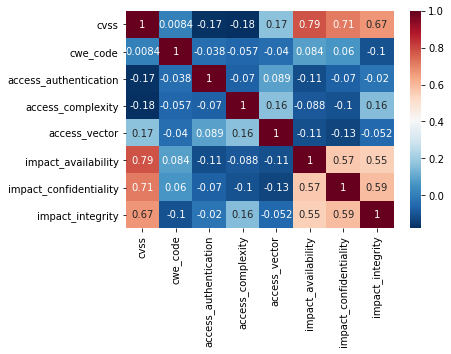

In [17]:
correlation_matrix = cve.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r")
plt.show()

Interestingly there seems to be a relatively strong correlation between the cvss and the impact on the availability, confidentiality or integrity (in this order), which was also to be expected.

In [18]:
# save the dataframe to a new file
cve.to_csv('cve_cleaned.csv', index = True, encoding='utf-8-sig')

In [19]:
cve = pd.read_csv('cve_cleaned.csv', encoding='utf-8-sig', engine='python')

In [20]:
cve.mod_date = pd.to_datetime(cve.mod_date)
cve.pub_date = pd.to_datetime(cve.pub_date)

***
**Publication Date**
***

In [21]:
least_recent_date = cve.pub_date.min()
least_recent_date

Timestamp('1999-01-01 05:00:00')

In [22]:
most_recent_date = cve.pub_date.max()
most_recent_date

Timestamp('2019-11-14 15:15:00')

In [23]:
def getMonth(pub_date):
    return(pub_date.strftime('%B'))
 
def getYear(pub_date):
    return(pub_date.strftime('%Y'))
 
# Applying the month and year extractor functions
cve['month']=cve['pub_date'].apply(getMonth)
cve['year']=cve['pub_date'].apply(getYear)

In [24]:
z = cve['month'].value_counts()

z1 = z.to_dict() #converts to dictionary

cve['count'] = cve['month'].map(z1)

In [25]:
months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
cve["month"] = pd.Categorical(cve["month"], categories = months_categories)
cve = cve.sort_values(by = ["month", "year"])

In [26]:
cve.head()

Unnamed: 0            mod_date            pub_date  cvss  cwe_code  \
34101  CVE-1999-0349 2018-10-12 21:29:00 1999-01-27 05:00:00   7.5       119   
39217  CVE-1999-0348 2018-08-13 21:47:00 1999-01-27 05:00:00   5.0       200   
65914  CVE-1999-0656 2017-07-11 01:29:00 1999-01-01 05:00:00   5.0        16   
67518  CVE-1999-0226 2017-05-03 16:18:00 1999-01-01 05:00:00  10.0        19   
87571  CVE-1999-0453 2008-09-05 20:17:00 1999-01-01 05:00:00   5.0       200   

                                                cwe_name  \
34101   Improper Restriction of Operations within the...   
39217                               Information Exposure   
65914                                      Configuration   
67518                             Data Processing Errors   
87571                               Information Exposure   

                                                 summary  \
34101  A buffer overflow in the FTP list (ls) command...   
39217  IIS ASP caching problem releases sensitive inf...   
65914  The ugidd RPC interface, by design, allows rem...   
67518  Windows NT TCP/IP processes fragmented IP pack...   
87571  An attacker can identify a CISCO device by sen...   

       access_authentication  access_complexity  access_vector  \
34101                      0                  0              1   
39217                      0                  0              1   
65914                      0                  0              1   
67518                      0                  0              1   
87571                      0                  0              1   

       impact_availability  impact_confidentiality  impact_integrity    month  \
34101                    1                       1                 1  January   
39217                    0                       1                 0  January   
65914                    0                       1                 0  January   
67518                    2                       2                 2  January   
87571                    0                       1                 0  January   

       year  count  
34101  1999   6308  
39217  1999   6308  
65914  1999   6308  
67518  1999   6308  
87571  1999   6308

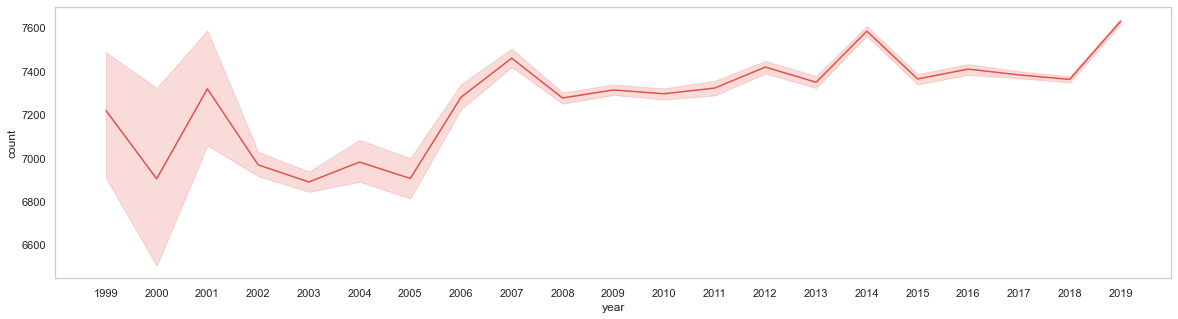

In [27]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot('year', 'count', data=cve)

In [28]:
cve_gr = pd.DataFrame({'count' : cve.groupby( [ "year", "month"] ).size()}).reset_index()

In [29]:
cve_gr['count'] = cve_gr['count'].replace(0, 1)

**Time series decomposition plot**

The time series decomposition plot provides a useful model for thinking about time series. Decomposition assumes that a time series can be broken down into a combination of the following components:
- level — the average value of the series,
- trend — an increasing/decreasing pattern in the series,
- seasonality — a repeating short-term cycle in the series,
- noise — the random, unexplainable variation.

While all time series have the level and noise components, while the trend and seasonality are optional.

What is left to add is that there are two main types of decomposition models:
- additive — it assumes that the components above are added together (linear model). The changes over time are more or less constant.
- multiplicative — it assumes that the components are multiplied by each other. Hence, the changes over time are non-linear and not constant, so they can increase/decrease with time. An example could be exponential growth.

For our case, when looking at the time plot we can see that there is monthly seasonality (12 periods, but that can be determined automatically given there is a timestamp index in the DataFrame) and the changes over time are not constant (increasing), so we will go with the multiplicative model.

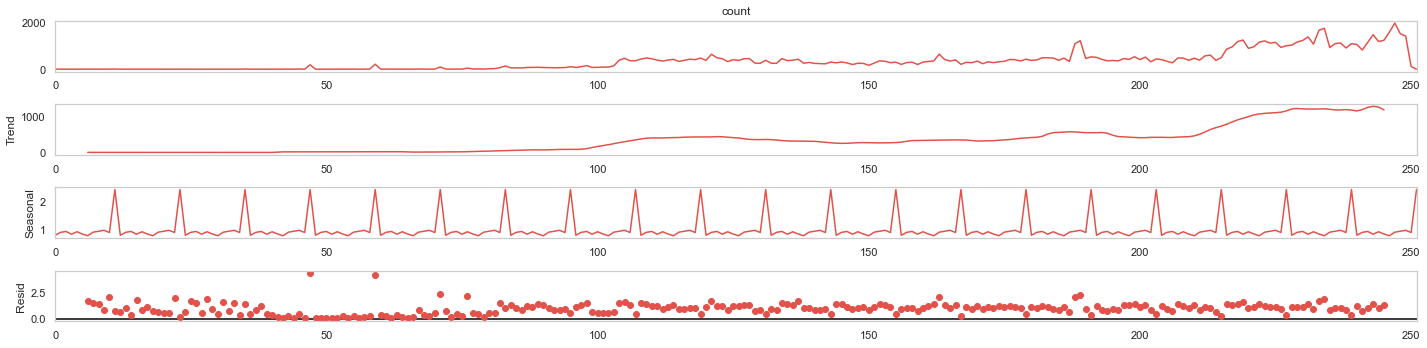

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(cve_gr['count'], 
                                   model='multiplicative', 
                                   period=12)
decomposition.plot();

In the plot we see the actual series in the first part, then the trend component, the seasonal one, and lastly the residuals (error term). 

The residuals in the multiplicative model suggest a good fit (they should be close to 0 for the additive one).

As always with automatic approaches, we should do a simple sanity check and do not trust the results blindly. For this simple example, we can see the confirmation of what we initially suspected about the time series.

**Autocorrelation plots**

When measuring the correlation between the time series and its lagged values (from previous points in time) we are talking about autocorrelation. There are two types of autocorrelation plots we can use.

The **autocorrelation function (ACF)** shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.

In contrast, the **partial autocorrelation function (PACF)** looks at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

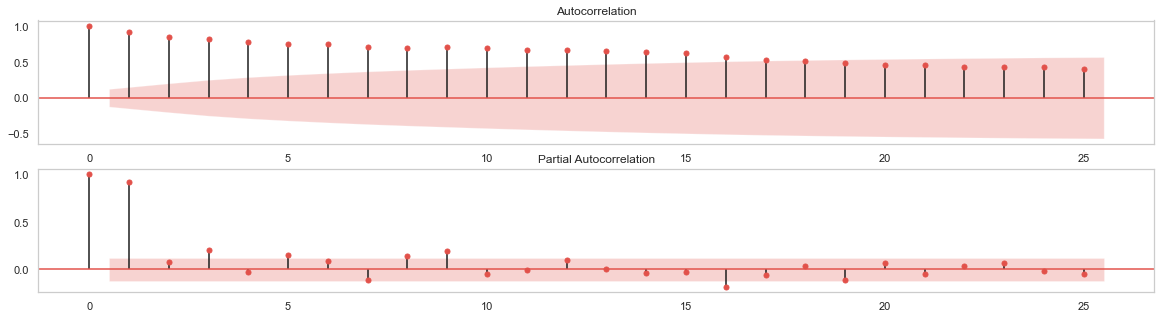

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

fig, ax = plt.subplots(2)
plot_acf(cve_gr['count'], ax=ax[0])
plot_pacf(cve_gr['count'], ax=ax[1]);

In the ACF plot, we can see that there are significant autocorrelations (above the 95% confidence interval, corresponding to the default 5% significance level). There are also some significant autocorrelations in the PACF plot.

Normally, the autocorrelations plots are often used for determining the stationarity of the time series or choosing the hyperparameters of the ARIMA class models.

***
***

So far we have looked at the threats as the number of threats on a yearly basis. How about a cummulative view, to see how the total threats evolved over time?

In [32]:
y = cve.pub_date.dt.to_period('Q').sort_index().value_counts()
y.index = y.index.to_timestamp()
y = y.sort_index()
y[y.index] = np.cumsum(y.values)

In [33]:
fig = go.Figure([go.Bar(x=y.index, y=y.values, marker_color="lightblue", name="Threat proliferation")])

fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

An immediate first reaction would be to conclude that the threat proliferation is increasing exponentially over time. 

A time series is broadly classified into three categories of long-term fluctuations, short-term or periodic fluctuations, and random variations. A long-term variation or a trend shows the general tendency of the data to increase or decrease during a long period of time. The variation may be gradual but it is inevitably present. 

The moving average is commonly used with time series to smooth random short-term variations and to highlight other components (trend, season, or cycle) present in your data. The moving average is also known as rolling mean and is calculated by averaging data of the time series within k periods of time. 

This method uses the concept of ironing out the fluctuations of the data by taking the means. It measures the trend by eliminating the changes or the variations by means of a moving average. The simplest of the mean used for the measurement of a trend is the arithmetic means (averages).

The simple moving average is the unweighted mean of the previous M data points. The selection of M (sliding window) depends on the amount of smoothing desired since increasing the value of M improves the smoothing at the expense of accuracy.

In [34]:
rolling = cve.pub_date.dt.to_period('M').sort_index().value_counts()
rolling.index = rolling.index.to_timestamp()
rolling = rolling.sort_index()
rolling[rolling.index] = np.cumsum(rolling.values)
rolling = rolling.rolling(12, axis=0).sum().pct_change(axis=0)

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace0 = go.Bar(x=y.index, y=y.values, marker_color="lightblue", name="Threat proliferation")
trace1 = go.Scatter(x=rolling.index, y=rolling.values, marker_color="darkred", mode="lines", name="Cummulative moving average")

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=True)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

While the treat proliferation seems to increase exponentially, the moving average suggests a different trend, which is that while new threats appear every year, the trend points to a stabilization of the number of new threats per years.

***
**Severity**
***

The Common Vulnerability Scoring System (CVSS) is an open framework for describing the characteristics and severity of computer security exploits. These scores consider exploitability and impact alongside temporal and environmental factors. Scores range from 0 to 10.

In [36]:
y = cve.cvss.sort_values().astype('int').value_counts().sort_index()[1:]

In [37]:
fig = go.Figure([go.Bar(x=y.index.map(lambda x: "{}-{}".format(x-1,x)),
                        y=y.values/np.sum(y.values)*100, marker_color="darkred", 
                        text=np.vectorize(lambda x: str(x) + "%")(np.round((y.values/np.sum(y.values) * 100),1)),
                        textposition='outside')])

fig.update_layout(     
                showlegend=False,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

In [38]:
no_auth = (cve.access_authentication==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [39]:
single_auth = (cve.access_authentication==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [40]:
multiple_auth = (cve.access_authentication==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [41]:
trace0 = go.Scatter(x=no_auth.index.to_timestamp(), y=no_auth, marker_color="darkred", mode="lines", name="No authentication required")
trace1 = go.Scatter(x=single_auth.index.to_timestamp(), y=single_auth, marker_color="lightblue", mode="lines", name="Single authentication required")
trace2 = go.Scatter(x=multiple_auth.index.to_timestamp(), y=multiple_auth, marker_color="grey", mode="lines", name="Multiple authentication required")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

It is obvious that the threats that can be exploited when without authentication is much higher. Strangely enough, there seems to be no difference between single or multiple authentication. Perhaps it is a feature of the dataset, it might be interesting to check whether this feature is verified by successful exploits of the vulnerabilities or based on experts' estimations (which would explain the lack of difference; one would assume the stronger the authentication, the smaller the probability that the vulnerability can be exploited).

In [42]:
low_complexity = (cve.access_complexity==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [43]:
med_complexity = (cve.access_complexity==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [44]:
high_complexity = (cve.access_complexity==2).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [45]:
trace0 = go.Scatter(x=low_complexity.index.to_timestamp(), y=low_complexity, marker_color="darkred", mode="lines", name="Low access complexity")
trace1 = go.Scatter(x=med_complexity.index.to_timestamp(), y=med_complexity, marker_color="lightblue", mode="lines", name="Medium access complexity")
trace2 = go.Scatter(x=high_complexity.index.to_timestamp(), y=high_complexity, marker_color="grey", mode="lines", name="High access complexity")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

Interestingly, low access complexity was prevalent in the past, while medium and high access complexity required vulnerabilities were less present. However, in the past 10 years, the number of medium complexity vulnerabilities has increased considerably, while the low complexity vulnerabilities has decreased. This might be related to the access to information and the increasing interest in the topic. Vulnerabilities which require high complexity are stable at a very low level.

In [46]:
local_attack_vector = (cve.access_vector==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [47]:
network_attack_vector = (cve.access_vector==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [48]:
adj_attack_vector = (cve.access_vector==2).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [49]:
trace0 = go.Scatter(x=local_attack_vector.index.to_timestamp(), y=local_attack_vector, marker_color="darkred", mode="lines", name="Local attack vector")
trace1 = go.Scatter(x=network_attack_vector.index.to_timestamp(), y=network_attack_vector, marker_color="lightblue", mode="lines", name="Network attack vector")
trace2 = go.Scatter(x=adj_attack_vector.index.to_timestamp(), y=adj_attack_vector, marker_color="grey", mode="lines", name="Network adjacent attack vector")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

Most vulnerabilities are/can be exploited via the network, and the trends seem to have remained more or less stable in the past 20 years.

In [50]:
no_ia = (cve.impact_availability==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [51]:
part_ia = (cve.impact_availability==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [52]:
comp_ia = (cve.impact_availability==2).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [53]:
trace0 = go.Scatter(x=no_ia.index.to_timestamp(), y=no_ia, marker_color="darkred", mode="lines", name="No impact on availability")
trace1 = go.Scatter(x=part_ia.index.to_timestamp(), y=part_ia, marker_color="lightblue", mode="lines", name="Partial impact on availability")
trace2 = go.Scatter(x=comp_ia.index.to_timestamp(), y=comp_ia, marker_color="grey", mode="lines", name="Complete impact on availability")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

In [54]:
no_ic = (cve.impact_confidentiality==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [55]:
part_ic = (cve.impact_confidentiality==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [56]:
comp_ic = (cve.impact_confidentiality==2).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [57]:
trace0 = go.Scatter(x=no_ic.index.to_timestamp(), y=no_ic, marker_color="darkred", mode="lines", name="No impact on confidentiality")
trace1 = go.Scatter(x=part_ic.index.to_timestamp(), y=part_ic, marker_color="lightblue", mode="lines", name="Partial impact on confidentiality")
trace2 = go.Scatter(x=comp_ic.index.to_timestamp(), y=comp_ic, marker_color="grey", mode="lines", name="Complete impact on confidentiality")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

In [58]:
no_ii = (cve.impact_integrity==0).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [59]:
part_ii = (cve.impact_integrity==1).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [60]:
comp_ii = (cve.impact_integrity==2).groupby(cve.pub_date.dt.to_period('Y')).mean()

In [61]:
trace0 = go.Scatter(x=no_ii.index.to_timestamp(), y=no_ii, marker_color="darkred", mode="lines", name="No impact on integrity")
trace1 = go.Scatter(x=part_ii.index.to_timestamp(), y=part_ii, marker_color="lightblue", mode="lines", name="Partial impact on integrity")
trace2 = go.Scatter(x=comp_ii.index.to_timestamp(), y=comp_ii, marker_color="grey", mode="lines", name="Complete impact on integrity")

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace0)
fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=False)
fig.update_layout(     
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                bargap=0
)
fig.show()

Although less obvious there are also patterns here: partial impact on either availability, confidentiality or integrity are more likely than no impact. Complete impact are the least likely, which is also to be expected.

***
**Exploit Types**
***

In [62]:
y = pd.get_dummies(
        cve.cwe_name[cve.cwe_name.isin(cve.cwe_name.value_counts()[:10].index)]
    ).join(
        cve.pub_date
    ).groupby(
        cve.pub_date.dt.to_period("D")
).sum()

y.index = y.index.to_timestamp()
y = y.divide(y.sum(axis=1), axis=0)

In [63]:
colors = ['#ababab', '#cb4b16', '#268bd2', '#ebebeb', '#2aa198', '#dc322f', '#bbbbbb', '#9b9b9b', '#cbcbcb', '#dbdbdb']
fig = go.Figure()

# One trace for each column
for ndx in range(y.shape[1]):
    data = y.iloc[:,ndx].rolling(365,axis=0).mean() 
    fig.add_trace(go.Scatter(
        x=data.index[365:],
        y=data.values[365:], 
        name=y.columns[ndx] if "'" not in y.columns[ndx] else y.columns[ndx].split("'")[1],
        marker_color=colors[ndx]
    ))


fig.update_layout(     
                height=1100,
                width=800,
                showlegend=True,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                legend=dict(x=0., y=1.)
)
fig.show()

These are the 10 most common threats, but their relative prominence is shifting: injection (both code and SQL) is becoming less common while cross-site scripting and input validation are on the rise. 
Values are shown as a 365-entry (daily) rolling average of relative frequencies, and limited to the last 10 years (of the dataset) for visibility.

***
**Products**
***

In [64]:
products.head()

vulnerable_product
cve_id                               
CVE-2019-16548  google_compute_engine
CVE-2019-16547  google_compute_engine
CVE-2019-16546  google_compute_engine
CVE-2013-2092                dolibarr
CVE-2013-2091                dolibarr

In [65]:
products.shape

(180585, 1)

In [66]:
products.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 180585 entries, CVE-2019-16548 to CVE-2007-3004
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vulnerable_product  180543 non-null  object
dtypes: object(1)
memory usage: 24.5 MB


In [72]:
g = products.groupby(['vulnerable_product']).size().nlargest(20).reset_index(name='top20')

We can easily group these into operating systems, web browsers, mobile operating systems and other (like acrobat reader). 

In [104]:
def f(row):
    if (('linux' in row['vulnerable_product']) | ('windows' in row['vulnerable_product']) | ('mac' in row['vulnerable_product'])):
        val = 'OS'
    elif (('safari' in row['vulnerable_product']) | ('chrome' in row['vulnerable_product']) | ('firefox' in row['vulnerable_product']) | ('explorer' in row['vulnerable_product'])):
        val = 'Web'
    elif (('android' in row['vulnerable_product']) | ('iphone' in row['vulnerable_product'])):
        val = 'Mobile'
    else:
        val = 'Other'
    return val

In [105]:
# create a new column and use np.select to assign values to it using the lists as arguments
g['type'] = g.apply(f, axis=1)

In [149]:
colors = ["Darkred", "Lightblue", "Darkgrey", "Black"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

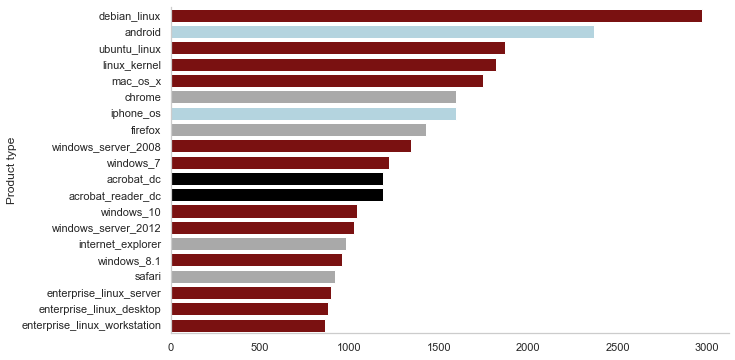

In [151]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(g['top20'], g['vulnerable_product'], data=g, hue='type', dodge=False, palette=customPalette)
plt.ylabel('Product type')
plt.xlabel('')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()

***
**Vendors**
***

In [67]:
vendors.head()

vendor
CVE-2019-16548   jenkins
CVE-2019-16547   jenkins
CVE-2019-16546   jenkins
CVE-2013-2092   dolibarr
CVE-2013-2091   dolibarr

In [68]:
vendors.shape

(101658, 1)

In [69]:
vendors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 101658 entries, CVE-2019-16548 to CVE-2007-3004
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   vendor  101616 non-null  object
dtypes: object(1)
memory usage: 13.1 MB


In [152]:
vendors.head()

vendor
CVE-2019-16548   jenkins
CVE-2019-16547   jenkins
CVE-2019-16546   jenkins
CVE-2013-2092   dolibarr
CVE-2013-2091   dolibarr

In [153]:
v = vendors.groupby(['vendor']).size().nlargest(20).reset_index(name='top20')

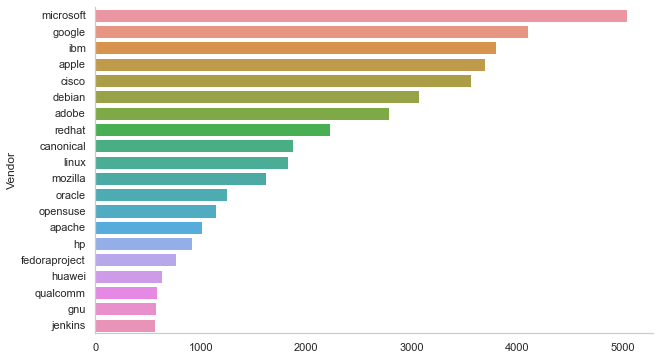

In [155]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(v['top20'], v['vendor'], data=g, dodge=False)
plt.ylabel('Vendor')
plt.xlabel('')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.get_legend().remove()